In [ ]:
# Import required libraries
import os
import gc
import sys
import json
import random
from pathlib import Path

import cv2 # CV2 for image manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm

from imgaug import augmenters as iaa

import seaborn as sns
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold

In [ ]:
!pip install tensorflow==1.5
!pip install keras==2.1.5

import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

In [ ]:
!ls /kaggle/input/imaterialist-fashion-2020-fgvc7/

In [ ]:
%%time
with open('/kaggle/input/imaterialist-fashion-2020-fgvc7/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
sample_sub_df = pd.read_csv('/kaggle/input/imaterialist-fashion-2020-fgvc7/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/imaterialist-fashion-2020-fgvc7/train.csv')

In [ ]:
train_df.head()

In [ ]:
sample_sub_df.head()

In [ ]:
print(f'Shape of training dataset: {train_df.shape}')

In [ ]:
print(f'# of images in training set: {train_df["ImageId"].nunique()}')
print(f'# of images in test set: {sample_sub_df["ImageId"].nunique()}')

### Image size analysis in training dataset

In [ ]:
pd.DataFrame([train_df['Height'].describe(), train_df['Width'].describe()]).T.loc[['max', 'min', 'mean']]

### Height and Width destribution of training images

In [ ]:
image_shape_df = train_df.groupby("ImageId")["Height", "Width"].first()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(image_shape_df['Height'], bins=100)
ax1.set_title("Height distribution")
ax2.hist(image_shape_df['Width'], bins=100)
ax2.set_title("Width distribution")
plt.show()

### Image with minimum height

In [ ]:
plt.figure(figsize = (70,7))
min_height = list(set(train_df[train_df['Height'] == train_df['Height'].min()]['ImageId']))[0]
plt.imshow(mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{min_height}.jpg'))
plt.grid(False)
plt.show()

### Image with maximum height

In [ ]:
plt.figure(figsize = (70,7))
max_height = list(set(train_df[train_df['Height'] == train_df['Height'].max()]['ImageId']))[0]
plt.imshow(mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{max_height}.jpg'))
plt.grid(False)
plt.show()

### Image with minimum width

In [ ]:
plt.figure(figsize = (70,7))
min_width = list(set(train_df[train_df['Width'] == train_df['Width'].min()]['ImageId']))[0]
plt.imshow(mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{min_width}.jpg'))
plt.grid(False)
plt.show()

### Image with maximum width

In [ ]:
plt.figure(figsize = (70,7))
max_width = list(set(train_df[train_df['Width'] == train_df['Width'].max()]['ImageId']))[0]
plt.imshow(mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{max_width}.jpg'))
plt.grid(False)
plt.show()

In [ ]:
area_df = pd.DataFrame()
area_df['ImageId'] = train_df['ImageId']
area_df['area'] = train_df['Height'] * train_df['Width']
min_area = list(set(area_df[area_df['area'] == area_df['area'].min()]['ImageId']))[0]
max_area = list(set(area_df[area_df['area'] == area_df['area'].max()]['ImageId']))[0]

### Image with minimum area

In [ ]:
plt.figure(figsize = (70,7))
plt.imshow(mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{min_area}.jpg'))
plt.grid(False)
plt.show()

### Image with maximum area

In [ ]:
plt.figure(figsize = (70,7))
plt.imshow(mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{max_area}.jpg'))
plt.grid(False)
plt.show()

## Details about Classes and Attributes

In [ ]:
num_classes = len(label_desc['categories'])
num_attributes = len(label_desc['attributes'])
print(f'Total # of classes: {num_classes}')
print(f'Total # of attributes: {num_attributes}')

In [ ]:
categories_df = pd.DataFrame(label_desc['categories'])
attributes_df = pd.DataFrame(label_desc['attributes'])
categories_df

In [ ]:
pd.set_option('display.max_rows', 300)
attributes_df

## Plotting a few training images without any masks

In [ ]:
def plot_images(size=12, figsize=(12, 12)):
    # First get some images to be plotted
    image_ids = train_df['ImageId'].unique()[:12]
    images=[]
    
    for image in image_ids:
        images.append(mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{image}.jpg'))
    
    # Plot images in groups of 4 images
    n_groups = 4
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images[count])
                col.axis('off')
                count += 1
        plt.show()
    gc.collect()

In [ ]:
plot_images()

## Plotting a few images with given segments

In [ ]:
def create_mask(size):
    image_ids = train_df['ImageId'].unique()[:size]
    images_meta=[]

    for image_id in image_ids:
        img = mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{image_id}.jpg')
        images_meta.append({
            'image': img,
            'shape': img.shape,
            'encoded_pixels': train_df[train_df['ImageId'] == image_id]['EncodedPixels'],
            'class_ids':  train_df[train_df['ImageId'] == image_id]['ClassId']
        })

    masks = []
    for image in images_meta:
        shape = image.get('shape')
        encoded_pixels = list(image.get('encoded_pixels'))
        class_ids = list(image.get('class_ids'))
        
        # Initialize numpy array with shape same as image size
        height, width = shape[:2]
        mask = np.zeros((height, width)).reshape(-1)
        
        # Iterate over encoded pixels and create mask
        for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            assert max(pixel_starts) < mask.shape[0]
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1
                run_length = int(run_length)
                mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4
        masks.append(mask.reshape((height, width), order='F'))  # https://stackoverflow.com/questions/45973722/how-does-numpy-reshape-with-order-f-work
    return masks, images_meta

In [ ]:
def plot_segmented_images(size=12, figsize=(14, 14)):
    # First create masks from given segments
    masks, images_meta = create_mask(size)
    
    # Plot images in groups of 4 images
    n_groups = 4
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images_meta[count]['image'])
                col.imshow(masks[count], alpha=0.75)
                col.axis('off')
                count += 1
        plt.show()
    gc.collect()

In [ ]:
plot_segmented_images()

## Analysing Categories and Attributes

In [ ]:
categories_df = pd.DataFrame(label_desc.get('categories'))
attributes_df = pd.DataFrame(label_desc.get('attributes'))

In [ ]:
print(f'# of categories: {len(categories_df)}')
print(f'# of attributes: {len(attributes_df)}')

So there are 46 categories (classes) and 294 attributes. Let's see some of the categories and attributes

In [ ]:
categories_df.head()

In [ ]:
attributes_df.head()

In [ ]:
category_map, attribute_map = {}, {}
for cat in label_desc.get('categories'):
    category_map[cat.get('id')] = cat.get('name')
for attr in label_desc.get('attributes'):
    attribute_map[attr.get('id')] = attr.get('name')

In [ ]:
train_df['ClassId'] = train_df['ClassId'].map(category_map)
train_df['ClassId'] = train_df['ClassId'].astype('category')

### Let's see the class wise distribution of segments in training dataset

In [ ]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (10,10))
sns.countplot(y='ClassId',data=train_df , ax=ax, order = train_df['ClassId'].value_counts().index)
fig.show()

### Now let's visualize an image with all its classes and attributes

In [ ]:
IMAGE_ID = '000b3ec2c6eaffb491a5abb72c2e3e26'

In [ ]:
# Get the an image id given in the training set for visualization
vis_df = train_df[train_df['ImageId'] == IMAGE_ID]
vis_df['ClassId'] = vis_df['ClassId'].cat.codes
vis_df = vis_df.reset_index(drop=True)
vis_df

From above table, this image has 8 segmentes and a few attributes. Let's visualize all of them!

## Let's first the plot the plain image

In [ ]:
plt.figure(figsize = (110,11))
image = mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{IMAGE_ID}.jpg')
plt.grid(False)
plt.imshow(image)
plt.plot()

In [ ]:
train_df[train_df['ImageId'] == IMAGE_ID]

## Now let's plot each segment in a separate image

In [ ]:
segments = list(vis_df['EncodedPixels'])
class_ids = list(vis_df['ClassId'])
masks = []
for segment, class_id in zip(segments, class_ids):
    
    height = vis_df['Height'][0]
    width = vis_df['Width'][0]
    # Initialize empty mask
    mask = np.zeros((height, width)).reshape(-1)
    
    # Iterate over encoded pixels and create mask
    splitted_pixels = list(map(int, segment.split()))
    pixel_starts = splitted_pixels[::2]
    run_lengths = splitted_pixels[1::2]
    assert max(pixel_starts) < mask.shape[0]
    for pixel_start, run_length in zip(pixel_starts, run_lengths):
        pixel_start = int(pixel_start) - 1
        run_length = int(run_length)
        mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4

    mask = mask.reshape((height, width), order='F')
    masks.append(mask)

In [ ]:
def plot_individual_segment(*masks, image, figsize=(110, 11)):
    plt.figure(figsize = figsize)
    plt.imshow(image)
    for mask in masks:
        plt.imshow(mask, alpha=0.6)
    plt.axis('off')
    plt.show()

## Plotting 1st Segment: ClassId: "Shoe" and no attributes 

In [ ]:
plot_individual_segment(masks[0], image=image)

## Plotting 2nd Segment: ClassId: "shoe"

In [ ]:
plot_individual_segment(masks[1], image=image)

## Plotting 3rd Segment with ClassId: "pants"

In [ ]:
plot_individual_segment(masks[2], image=image)

## Plotting 4th Segment with ClassId: "top, t-shirt, sweatshirt"

In [ ]:
plot_individual_segment(masks[3], image=image)

## Plotting 5th Segment with ClassId: "pocket"

In [ ]:
plot_individual_segment(masks[4], image=image)

## Plotting 6th Segment with ClassId: "sleeve"

In [ ]:
plot_individual_segment(masks[5], image=image)

## Plotting 7th Segment with ClassId: "sleeve"

In [ ]:
plot_individual_segment(masks[6], image=image)

## Plotting 8th segment with Class "neckline"

In [ ]:
plot_individual_segment(masks[6], image=image)

Some of the segments have no attributes. Let's check how many such segment exists in training dataset.

In [ ]:
print(f'Segments that do not have attributes: {train_df["AttributesIds"].isna().sum()/len(train_df) * 100} %')

Let's check of missing values in training dataset for columns other than "AttributeIds"

In [ ]:
train_df[['ImageId', 'EncodedPixels', 'Height', 'Width', 'ClassId']].isna().sum()

## Data Preparation and modeling

In [ ]:
train_df

In [ ]:
train_df['ClassId'] = train_df['ClassId'].cat.codes

In [ ]:
train_df

Drop attributeIds for simplicity for now. TODO: Need to take this in consideration once the basic model is ready with ClassId

In [ ]:
train_df = train_df.drop('AttributesIds', axis=1)

In [ ]:
image_df = train_df.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
size_df = train_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Reference: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb

In [ ]:
import os
from pathlib import Path
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

In [ ]:
# !cat /kaggle/working/Mask_RCNN/mrcnn/model.py

In [ ]:
DATA_DIR = Path('/kaggle/input/imaterialist-fashion-2020-fgvc7')
ROOT_DIR = Path('/kaggle/working')

In [ ]:
import sys

In [ ]:
# sys.path = sys.path[:-1]

In [ ]:
# sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
class FashionConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "class"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    BACKBONE = 'resnet50'
    # Number of classes (including background)
    NUM_CLASSES = 1 + len(categories_df)  # background + 46 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = FashionConfig()
config.display()

In [ ]:
class FashionDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)
        
        self.IMAGE_SIZE = 256
        
        # Add classes
        for cat in label_desc['categories']:
            self.add_class('fashion', cat.get('id'), cat.get('name'))
        
        # Add images
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name) + '.jpg', 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
            
    def _resize_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
        return img
        
    def load_image(self, image_id):
        return self._resize_image(self.image_info[image_id]['path'])
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [x for x in info['labels']]
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

In [ ]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)

    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [ ]:
# Training on a very small subset of the data for fast results for now.
# image_df = image_df.iloc[0:2]

In [ ]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 2

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

In [ ]:
print(train_df.shape)
print(valid_df.shape)

## Training

In [ ]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
EPOCHS = [1, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

Let's load the COCO dataset weights to our Model.

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history

In [ ]:
# %%time
 model.train(train_dataset, valid_dataset,
             learning_rate=LR,
             epochs=EPOCHS[1],
             layers='all',
             augmentation=augmentation)

 new_history = model.keras_model.history.history
 for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
# %%time
# model.train(train_dataset, valid_dataset,
#             learning_rate=LR/5,
#             epochs=EPOCHS[2],
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
epochs = range(EPOCHS[0])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

In [ ]:
import glob

In [ ]:
glob_list = glob.glob(f'/kaggle/working/class*/mask_rcnn_class_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

In [ ]:
sample_df = sample_sub_df

In [ ]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [ ]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [ ]:
IMAGE_SIZE = 256

In [ ]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [ ]:
%%time
import itertools
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df[:100].iterrows(), total=100):
    image = resize_image(str(DATA_DIR/'test'/row['ImageId']) + '.jpg')
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label, np.NaN])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23, np.NaN])
        missing_count += 1

In [ ]:
sample_sub_df.columns

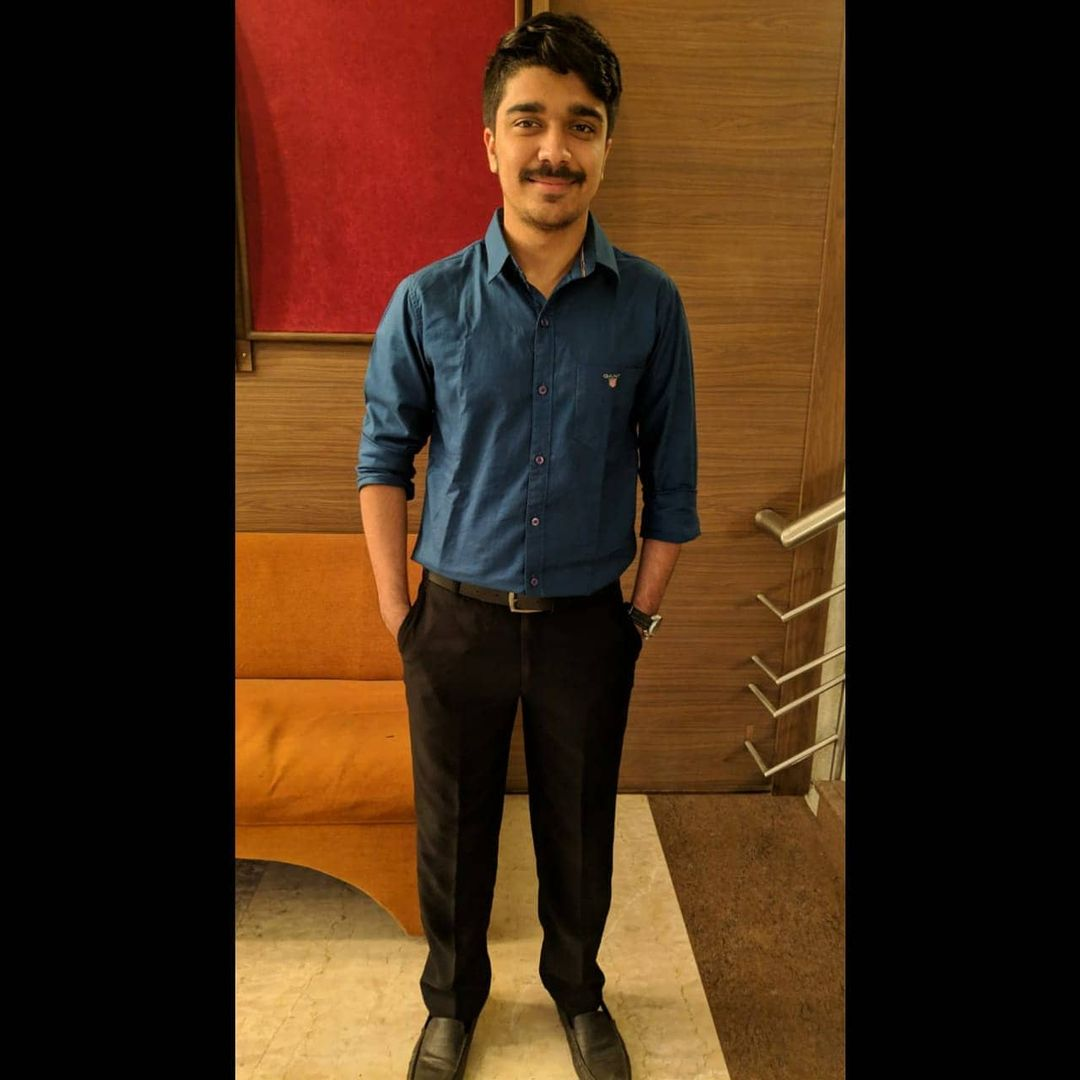

In [ ]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()


# added part for visualizing images
# Let’s load an image and try to see how the model performs. You can use any of your images to test the model.

# Load a random image from the images folder
import skimage.io
image_path = str(ROOT_DIR/'tejas.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(skimage.io.imread(image_path))

img = skimage.io.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = model.detect([resize_image(image_path)])
r = result[0]

if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    y_scale = img.shape[0]/IMAGE_SIZE
    x_scale = img.shape[1]/IMAGE_SIZE
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
    
    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']
    
visualize.display_instances(img, rois, masks, r['class_ids'], 
                            ['bg']+label_names, r['scores'])
cv2.imshow("name",img)

In [ ]:
# submission_df.to_csv("submission.csv", index=False)

In [ ]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

# In Progress... Stay Tuned!